<a href="https://colab.research.google.com/github/rfahreza/SkintoneClassifier/blob/main/skintone_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
import zipfile
import random
from typing import List, Tuple
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import os
from pathlib import Path
from typing import List, Tuple
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import random
from tqdm import tqdm
import cv2
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import display
import requests
from ipywidgets import widgets, interact
import io
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annisapermatabunda","key":"1c23eb523d8891f9fd1ebddb41263682"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d usamarana/skin-tone-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/usamarana/skin-tone-classification-dataset
License(s): unknown
  0% 0.00/7.35M [00:00<?, ?B/s]
100% 7.35M/7.35M [00:00<00:00, 785MB/s]


In [7]:
!unzip -q skin-tone-classification-dataset.zip -d /content/

In [8]:
folder_path = '/content/train'
files = os.listdir(folder_path)

print("Isi folder:", files)


Isi folder: ['White', 'Black', 'Brown']


In [9]:
train_dir = '/content/train'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=32,
    class_mode='categorical', subset='training')
val_gen = datagen.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=32,
    class_mode='categorical', subset='validation')

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [10]:
def plot_category_samples(
    dataset_path: str = "train/",
    samples_per_category: int = 5,
    figsize: tuple = (14, 6),
    label_fontsize: int = 12,
    dpi: int = 100
) -> plt.Figure:
    """
    Menampilkan beberapa sampel gambar dari setiap kategori dalam dataset.

    Parameters:
    - dataset_path: Lokasi direktori dataset.
    - samples_per_category: Banyaknya gambar yang ditampilkan per kategori.
    - figsize: Ukuran keseluruhan figure (lebar, tinggi).
    - label_fontsize: Ukuran font untuk label kategori.
    - dpi: Resolusi gambar output.

    Returns:
    - Objek Figure dari matplotlib.
    """
    root_path = Path(dataset_path)

    if not root_path.exists():
        raise FileNotFoundError(f"Direktori '{dataset_path}' tidak ditemukan.")
    if not root_path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan sebuah folder.")

    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    categories = []

    # Memfilter folder yang berisi gambar
    for folder in root_path.iterdir():
        if folder.is_dir():
            files = list(folder.glob("*"))
            if any(file.suffix.lower() in valid_extensions for file in files):
                categories.append(folder.name)

    categories.sort()

    if not categories:
        print("Tidak ditemukan kategori dengan gambar valid.")
        return None

    n_rows = len(categories)
    n_cols = samples_per_category
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] + n_rows * 0.5),
        dpi=dpi,
        gridspec_kw={'wspace': 0.05, 'hspace': 0.3}
    )

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    max_label_length = max(len(cat) for cat in categories)
    plt.subplots_adjust(left=0.2 + 0.01 * max_label_length)

    for row_idx, category in enumerate(categories):
        category_path = root_path / category
        image_files = [
            file for file in category_path.iterdir()
            if file.is_file() and file.suffix.lower() in valid_extensions
        ]

        sample_count = min(samples_per_category, len(image_files))
        selected_images = np.random.choice(image_files, size=sample_count, replace=False) if sample_count else []

        for col_idx in range(n_cols):
            ax = axes[row_idx, col_idx]
            ax.axis('off')
            ax.set_facecolor('#f0f0f0')

            if col_idx < len(selected_images):
                try:
                    img = Image.open(selected_images[col_idx])
                    ax.imshow(img)
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('#808080')
                        spine.set_linewidth(0.5)
                except (UnidentifiedImageError, OSError) as e:
                    _add_error_text(ax, f"Gagal membuka gambar: {e}")
            else:
                _add_error_text(ax, "Gambar tidak tersedia")

        axes[row_idx, 0].text(
            -0.3, 0.5,
            category,
            transform=axes[row_idx, 0].transAxes,
            fontsize=label_fontsize,
            fontweight='bold',
            va='center',
            ha='right',
            bbox=dict(
                boxstyle='round',
                facecolor='white',
                edgecolor='#404040',
                alpha=0.8,
                pad=0.3
            )
        )

    plt.show()
    return fig

def _add_error_text(ax, message: str):
    """Menampilkan pesan kesalahan pada subplot."""
    ax.text(
        0.5, 0.5,
        message,
        ha='center',
        va='center',
        fontsize=8,
        color='red',
        wrap=True
    )
    ax.set_facecolor('#fff0f0')


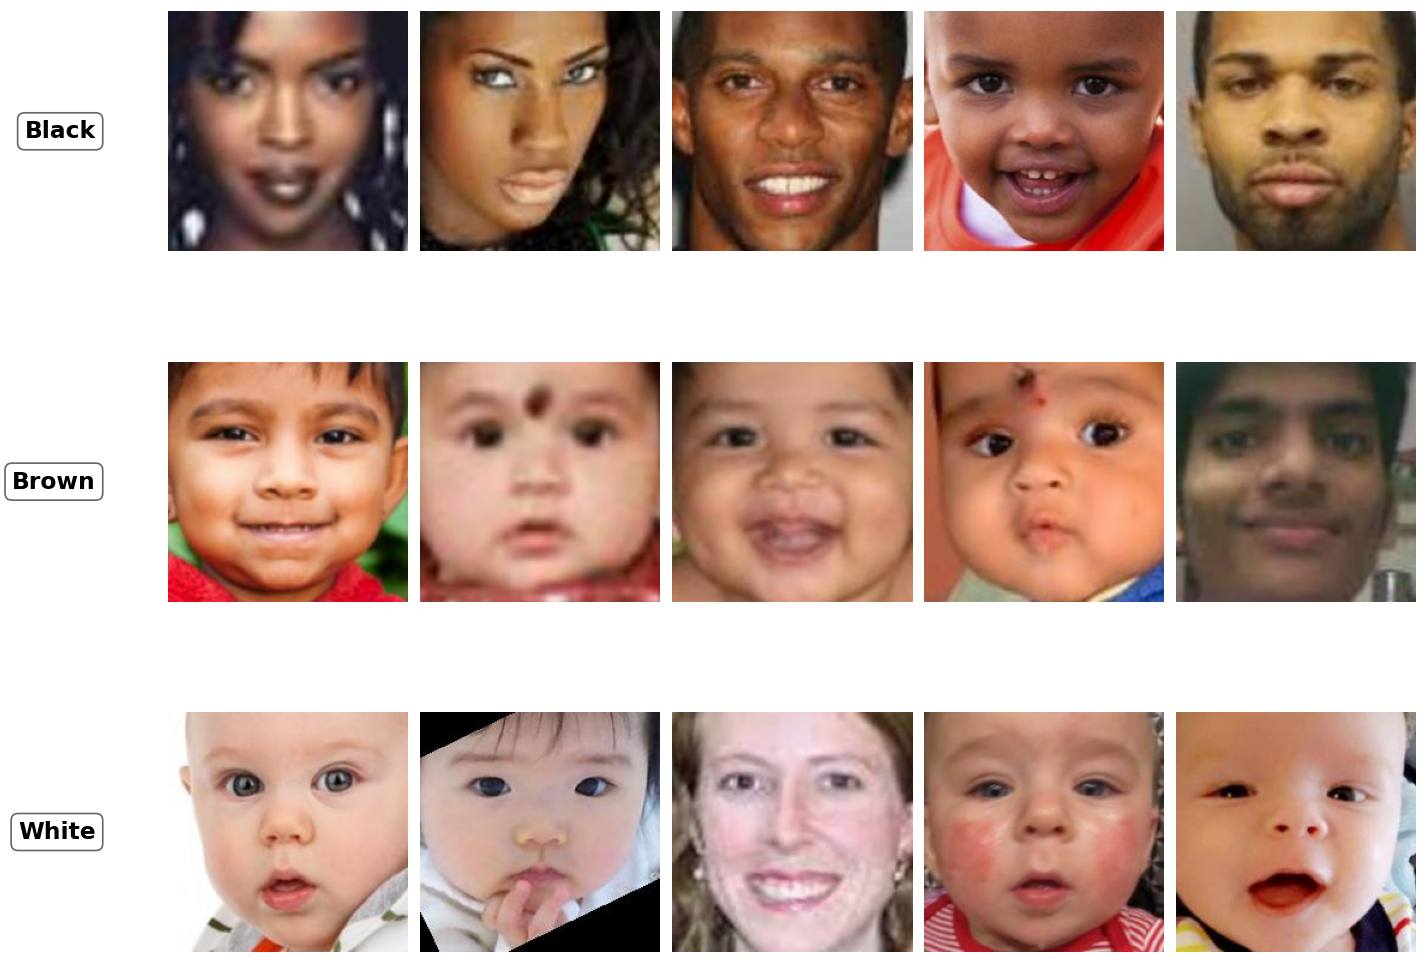

In [12]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="/content/train",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

def analyze_dataset_distribution(dataset_path: str = "train/") -> pd.DataFrame:
    """
    Menganalisis dan memvisualisasikan sebaran kategori gambar dalam dataset.

    Parameters:
    - dataset_path: Lokasi folder utama dataset

    Returns:
    - DataFrame berisi detail gambar (path, nama file, label, ekstensi)
    """
    base_path = Path(dataset_path)
    allowed_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    # Validasi direktori
    if not base_path.exists():
        raise FileNotFoundError(f"Direktori '{dataset_path}' tidak ditemukan.")
    if not base_path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan sebuah folder.")

    records = []
    for file in base_path.rglob('*'):
        if file.is_file() and file.suffix.lower() in allowed_extensions:
            label = file.relative_to(base_path).parts[0]
            records.append({
                "path": str(file),
                "file_name": file.name,
                "label": label,
                "extension": file.suffix.lower()
            })

    if not records:
        raise ValueError("Dataset tidak mengandung gambar dengan format valid.")

    df = pd.DataFrame(records)

    # Membuat visualisasi distribusi label
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(
        data=df,
        y="label",
        hue="label",
        order=df["label"].value_counts().index,
        palette="viridis",
        legend=False
    )

    total_images = len(df)
    for patch in ax.patches:
        count = patch.get_width()
        ax.annotate(
            f"{int(count)}\n({count/total_images:.1%})",
            (count + 0.5, patch.get_y() + patch.get_height() / 2),
            ha="left",
            va="center"
        )

    plt.title(f"Penyebaran Gambar pada Dataset - {total_images} Gambar dalam {df['label'].nunique()} Kategori", fontsize=14)
    plt.xlabel("Jumlah Gambar", labelpad=15)
    plt.ylabel("Kategori", labelpad=15)
    plt.xlim(0, df["label"].value_counts().max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df

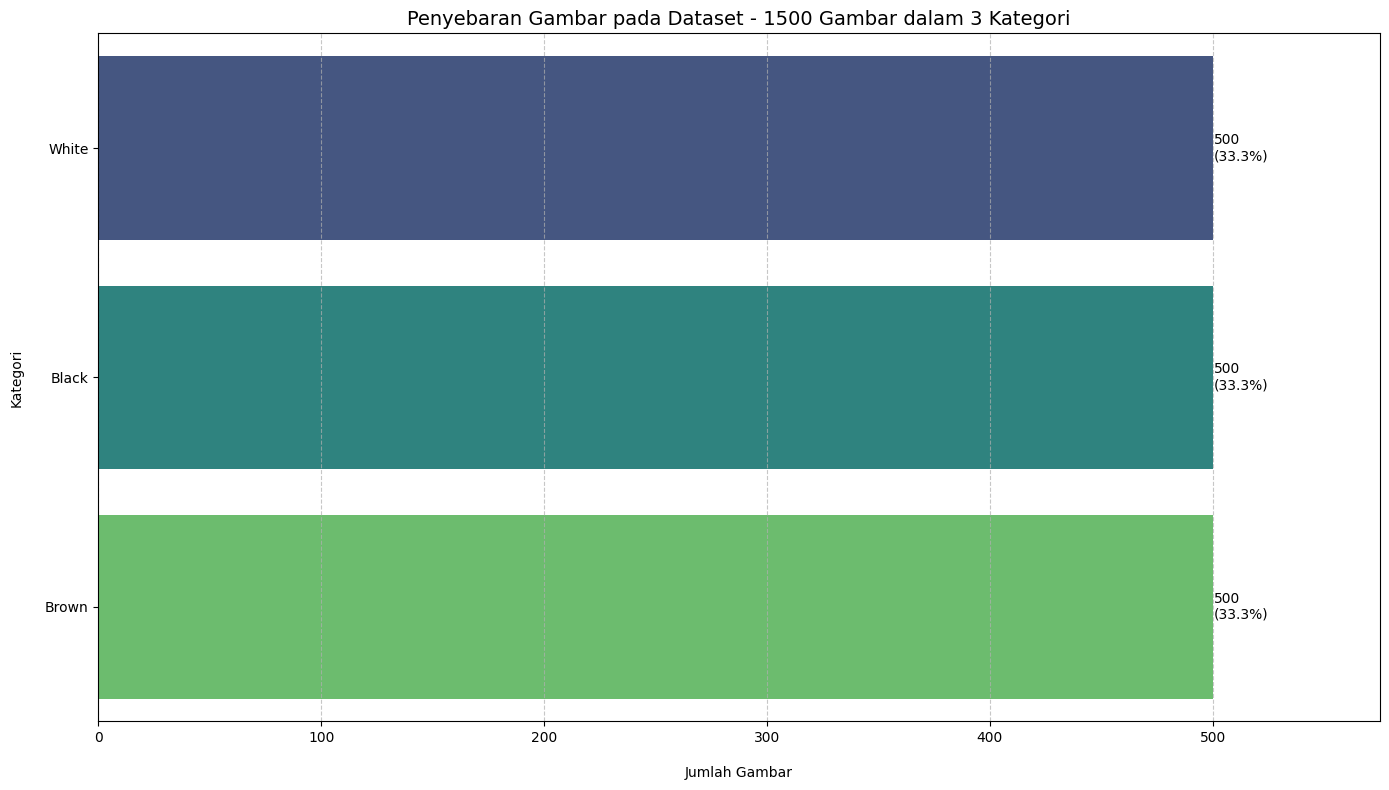

In [15]:
df_train = analyze_dataset_distribution("/content/train")

# Pre Processing Data

## Data Augmentation

In [16]:
import tensorflow as tf
import cv2
import numpy as np
import random
from pathlib import Path
from tqdm import tqdm
import shutil

class SkinToneAugmentor:
    def __init__(self, target_size=224):
        self.target_size = target_size
        self.augment_strategies = [
            self.rotate_softly,
            self.vary_color,
            self.inject_noise
        ]

    def rotate_softly(self, img):
        angle = random.uniform(-5, 5)
        img_np = img.numpy()
        h, w = img_np.shape[:2]
        matrix = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        rotated = cv2.warpAffine(img_np, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
        return tf.convert_to_tensor(rotated)

    def vary_color(self, img):
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_saturation(img, 0.9, 1.1)
        img = tf.image.random_hue(img, 0.08)
        return tf.clip_by_value(img, 0.0, 1.0)

    def inject_noise(self, img):
        mode = random.choice(['gaussian', 'speckle'])
        if mode == 'gaussian':
            noise = tf.random.normal(tf.shape(img), stddev=0.03)
        else:
            noise = img * tf.random.normal(tf.shape(img), mean=0.0, stddev=0.1)
        return tf.clip_by_value(img + noise, 0.0, 1.0)

    def apply(self, img):
        total_augs = len(self.augment_strategies)
        n = random.randint(2, min(4, total_augs))
        picked = random.sample(self.augment_strategies, k=n)
        for aug in picked:
            if random.random() < 0.8:
                img = aug(img)
        return img


def augment_image(img_path, save_dir, class_id, idx, augmentor):
    try:
        img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            return 0

        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

        resized = cv2.resize(img, (augmentor.target_size, augmentor.target_size))
        tensor_img = tf.convert_to_tensor(resized / 255.0, dtype=tf.float32)

        aug_img = augmentor.apply(tensor_img)
        final_img = (aug_img.numpy() * 255).astype(np.uint8)

        result_path = save_dir / f"{class_id}_aug_{idx}{img_path.suffix}"
        cv2.imwrite(str(result_path), final_img)
        return 1
    except Exception as err:
        print(f"Gagal memproses {img_path.name}: {err}")
        return 0


def augment_undertone_dataset(input_root="/content/train", output_root="train_augmented", desired_total=500):
    augmenter = SkinToneAugmentor()

    for class_folder in Path(input_root).iterdir():
        if not class_folder.is_dir():
            continue

        class_name = class_folder.name
        destination = Path(output_root) / class_name

        originals = list(class_folder.glob("*.*"))
        originals = [f for f in originals if f.suffix.lower() in {'.jpg', '.jpeg', '.png'}]

        if not destination.exists():
            destination.mkdir(parents=True, exist_ok=True)

            for orig_file in originals:
                shutil.copy(orig_file, destination / orig_file.name)

        aug_files = list(destination.glob("*.*"))
        current_total = len(aug_files)
        required = max(desired_total - current_total, 0)

        if required == 0:
            print(f"\n✅ {class_name}: jumlah cukup ({current_total}).")
            continue

        print(f"\n📈 Menambah data {class_name}: perlu {required} gambar.")
        success, attempts = 0, 0
        max_tries = required * 3

        with tqdm(total=required, desc=f"Augmentasi {class_name}") as pbar:
            while success < required and attempts < max_tries:
                source_img = random.choice(originals)
                attempts += 1
                result = augment_image(
                    source_img,
                    destination,
                    class_name,
                    current_total + success,
                    augmenter
                )
                if result:
                    pbar.update(1)
                    success += 1


if __name__ == "__main__":
    augment_undertone_dataset()



✅ White: jumlah cukup (500).

✅ Black: jumlah cukup (500).

✅ Brown: jumlah cukup (500).


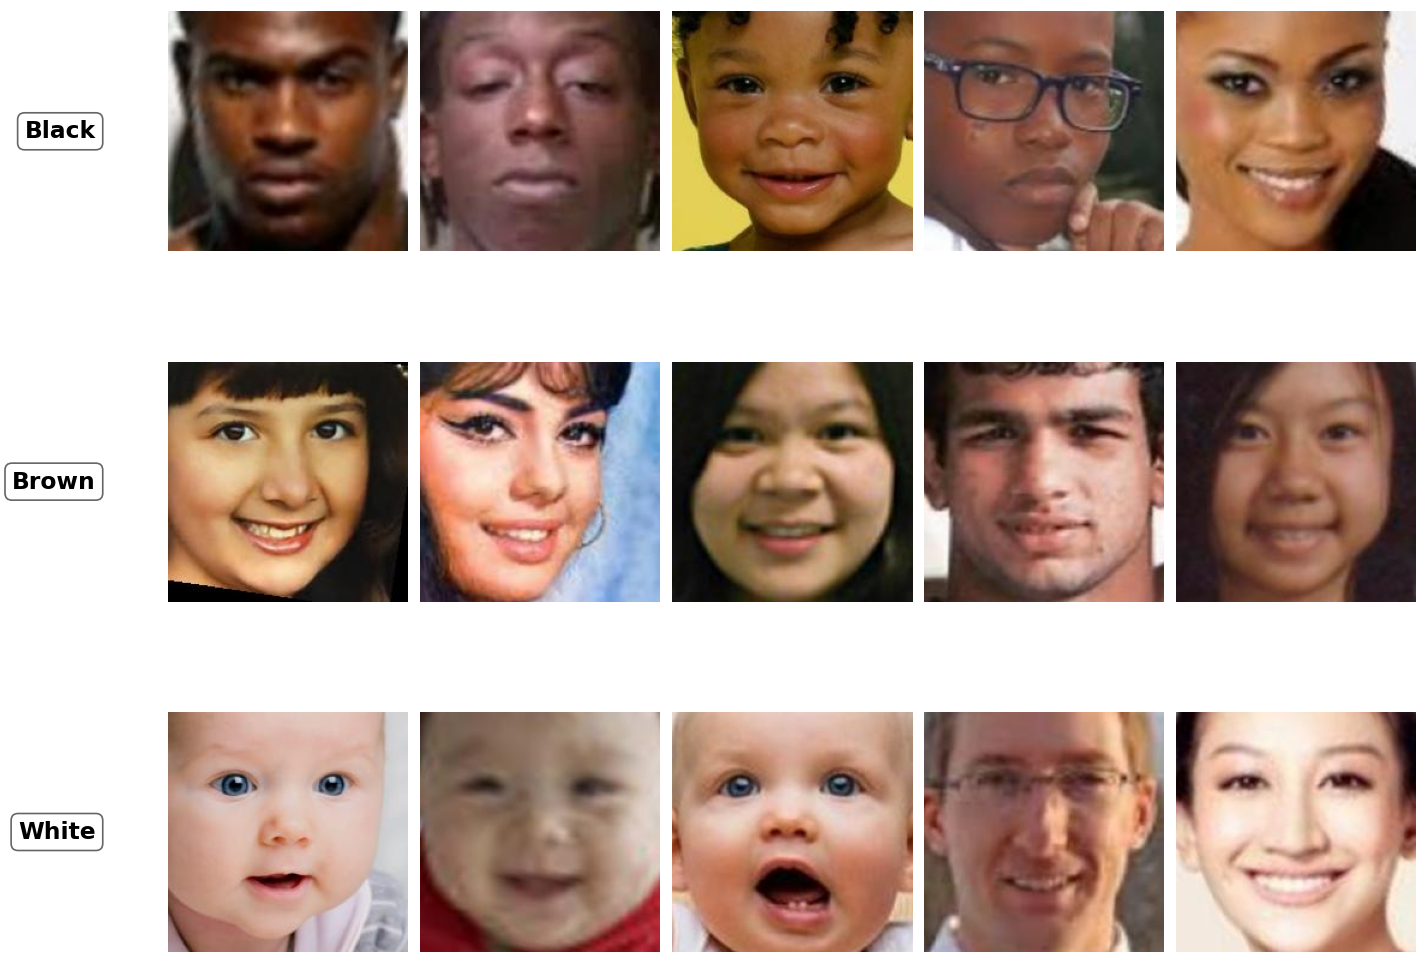

In [17]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="/content/train",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

In [18]:
def split_undertone_dataset(
    base_dir="train_augmented",
    output_dir="undertone_split_dataset",
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
):
    base_path = Path(base_dir)
    output_path = Path(output_dir)

    if output_path.exists():
        shutil.rmtree(output_path)
    output_path.mkdir(parents=True)

    for split in ["train", "val", "test"]:
        (output_path / split).mkdir(parents=True)

    for class_dir in base_path.iterdir():
        if not class_dir.is_dir():
            continue

        class_name = class_dir.name
        all_images = list(class_dir.glob("*.*"))
        all_images = [f for f in all_images if f.suffix.lower() in {".jpg", ".jpeg", ".png"}]
        random.shuffle(all_images)

        total = len(all_images)
        train_count = int(total * train_ratio)
        val_count = int(total * val_ratio)

        train_files = all_images[:train_count]
        val_files = all_images[train_count:train_count + val_count]
        test_files = all_images[train_count + val_count:]

        for split_name, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
            dest_dir = output_path / split_name / class_name
            dest_dir.mkdir(parents=True, exist_ok=True)
            for img_file in tqdm(split_files, desc=f"Copying {class_name} -> {split_name}"):
                shutil.copy(img_file, dest_dir / img_file.name)

    print(f"\n✅ Split selesai. Dataset tersedia di: '{output_dir}'")

if __name__ == "__main__":
    split_undertone_dataset()


Copying Brown -> test: 100%|██████████| 75/75 [00:00<00:00, 7108.83it/s]


✅ Split selesai. Dataset tersedia di: 'undertone_split_dataset'


In [19]:
TRAIN_DIR = "undertone_split_dataset/train"
VAL_DIR = "undertone_split_dataset/val"
TEST_DIR = "undertone_split_dataset/test"

basic_datagen = ImageDataGenerator(rescale=1./255)

train_generator = basic_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(64, 64),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_generator = basic_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(64, 64),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

test_generator = basic_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(64, 64),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)


Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [20]:
for x, y in train_generator:
    print(f"Input shape: {x.shape}")
    print(f"Label shape: {y.shape}")
    break

Input shape: (32, 64, 64, 3)
Label shape: (32, 3)


In [21]:
print("Kelas pada data train:", train_generator.class_indices)
print("Kelas pada data validasi:", val_generator.class_indices)
print("Kelas pada data test:", test_generator.class_indices)

Kelas pada data train: {'Black': 0, 'Brown': 1, 'White': 2}
Kelas pada data validasi: {'Black': 0, 'Brown': 1, 'White': 2}
Kelas pada data test: {'Black': 0, 'Brown': 1, 'White': 2}


# Modelling

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# tf.keras.backend.clear_session()

model_1 = Sequential()

# 1st Convolutional layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Fully Connected Layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Output Layer (multi-class)
model_1.add(Dense(3, activation='softmax'))

# Compile Model
model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,627 (1.29 MB)

 Trainable params: 338,435 (1.29 MB)

 Non-trainable params: 192 (768.00 B)

In [23]:
model_1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,587 (2.61 MB)

 Trainable params: 683,587 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import os
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_dir = 'undertone_split_dataset/train'

classes = os.listdir(train_dir)

class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

labels = []
for idx, class_name in enumerate(classes):
    labels += [idx] * class_counts[class_name]

class_weights_list = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

class_weights = {i : class_weights_list[i] for i in range(len(classes))}

print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow import keras

checkpoint_cb = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

history_1 = model_1.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks_list
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.3947 - loss: 1.0902
Epoch 1: val_loss improved from inf to 0.88807, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 0.3964 - loss: 1.0888 - val_accuracy: 0.5867 - val_loss: 0.8881 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.6110 - loss: 0.8479
Epoch 2: val_loss did not improve from 0.88807
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.6110 - loss: 0.8476 - val_accuracy: 0.5778 - val_loss: 0.8954 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6542 - loss: 0.7674
Epoch 3: val_loss improved from 0.88807 to 0.58764, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.6552 - loss: 0.7658 - val_accuracy: 0.7467 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7388 - loss: 0.6141
Epoch 4: val_loss did not impr

# Evaluasi dan Visualisasi

In [37]:
test_loss, test_acc = model_1.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4012
Test Accuracy: 0.8356


In [27]:
y_pred_probs = model_1.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

Text(0.5, 14.722222222222216, 'Predicted Label')

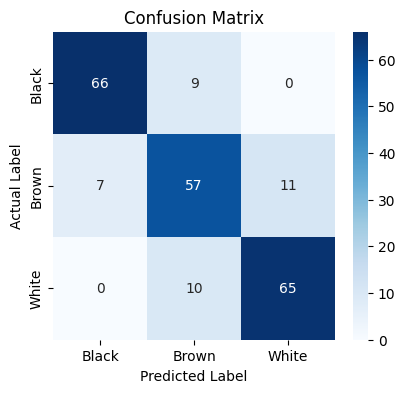

In [28]:
cm = confusion_matrix(test_generator.classes, y_pred_classes)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

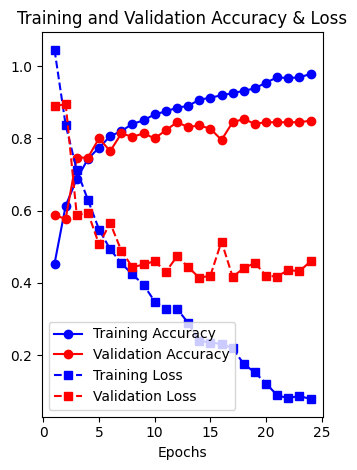

In [29]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.plot(epochs, loss, 'bs--', label='Training Loss')
plt.plot(epochs, val_loss, 'rs--', label='Validation Loss')
plt.title('Training and Validation Accuracy & Loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred_classes, target_names=test_generator.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

       Black       0.90      0.88      0.89        75
       Brown       0.75      0.76      0.75        75
       White       0.86      0.87      0.86        75

    accuracy                           0.84       225
   macro avg       0.84      0.84      0.84       225
weighted avg       0.84      0.84      0.84       225



In [31]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

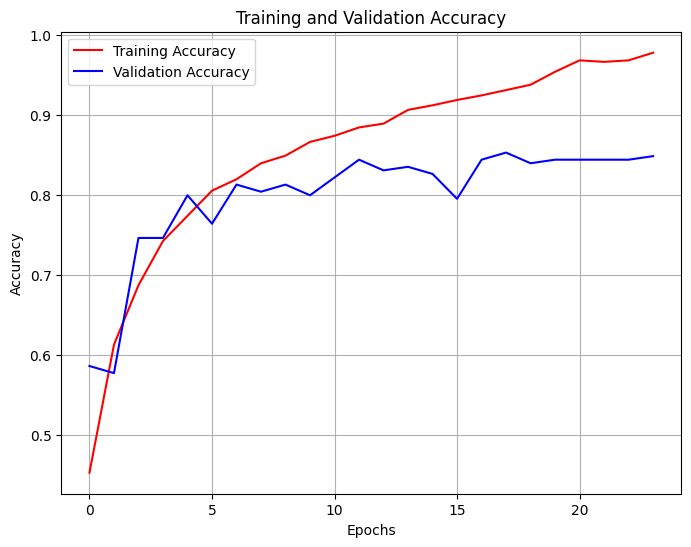

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

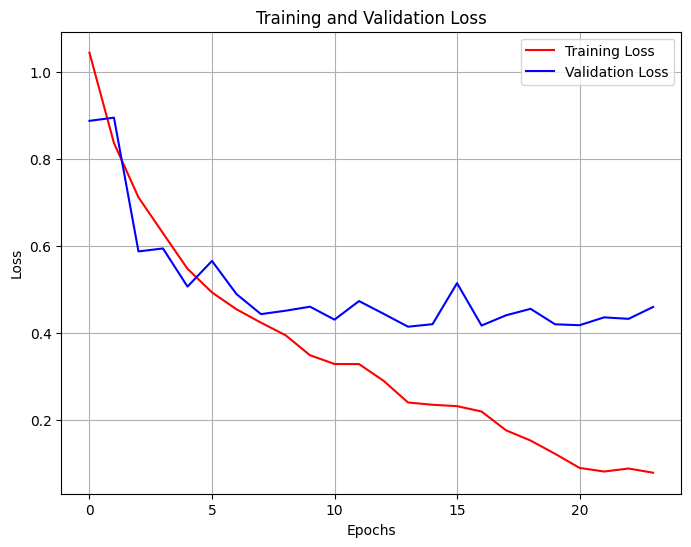

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
final_train_acc = history_1.history['accuracy'][-1]
final_val_acc = history_1.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 97.81%
Akurasi Validation Terakhir: 84.89%


In [40]:
print(f"Akurasi Tes Terakhir        : {test_acc:.2%}")

Akurasi Tes Terakhir        : 83.56%


### Inference

In [52]:
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB").resize((64, 64))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    label = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence * 100:.2f}%)")
    plt.show()

    return label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


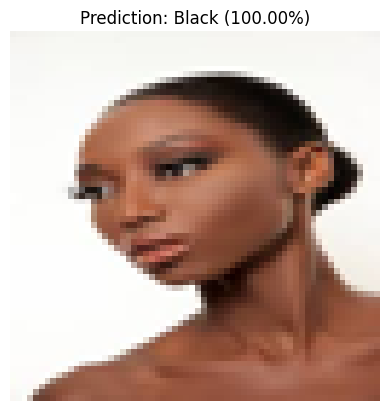

('Black', np.float32(0.9999962))

In [56]:
predict_image('/content/images.jpg')